In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from statistics import mean 

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
fires = pd.read_sql_query('select * from Fires', conn)

In [4]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

## Sample 10% of the dataset and begin the exploration
There are 1880645 rows in the full dataset, which makes running algorithms very costly during the development stage. The full dataset can be used again when the algorithms are finalized.

In [3]:
fires_sample = fires.sample(frac=1/10, random_state=1)
fires_sample.sample(10)

OBJECTID   FOD_ID                      FPA_ID SOURCE_SYSTEM_TYPE  \
615174     615175   663178        SFO-TX02230705-67350             NONFED   
518480     518481   558609         SFO-NC0258-009-0036             NONFED   
655905     655906   708737           SFO-TX0484-169268             NONFED   
636591     636592   687407        SFO-TX02240707-87911             NONFED   
1288876   1288877  1759636  SFO-NY-NY2614-2009-0000203             NONFED   
816095     816096   923180              STATE_MS_63210             NONFED   
336798     336799   345238                    W-504820                FED   
1237565   1237566  1640648     SFO-GA-FY2000-Floyd-085             NONFED   
20186       20187    20289                  FS-1450630                FED   
766984     766985   868914                    WA_15798             NONFED   

        SOURCE_SYSTEM NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
615174        ST-NASF                ST/C&L                USTXLAS   
518480        ST-NASF                ST/C&L                USNCNCS   
655905        ST-NASF                ST/C&L                USTXTXS   
636591        ST-NASF                ST/C&L                USTXTXS   
1288876       ST-NASF                ST/C&L                USNYNYX   
816095       ST-MSMSS                ST/C&L                USMSMSS   
336798       DOI-WFMI                   BLM                USNVSND   
1237565       ST-NASF                ST/C&L                USGAGAS   
20186     FS-FIRESTAT                    FS                USAZASF   
766984       ST-WAWAS                ST/C&L                USWAWAS   

                   NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  \
615174   Texas Forest Service - Linden Area                 TXLAS   
518480        North Carolina Forest Service                 NCNCS   
655905           Texas A & M Forest Service                 TXTXS   
636591           Texas A & M Forest Service                 TXTXS   
1288876         Fire Department of New York                NY2614   
816095      Mississippi Forestry Commission       MS East Central   
336798      Southern Nevada District Office                 NVLVD   
1237565         Georgia Forestry Commission                 GAGAS   
20186     Apache-Sitgreaves National Forest                  0301   
766984        Washington State Headquarters                 WAWAS   

                          SOURCE_REPORTING_UNIT_NAME LOCAL_FIRE_REPORT_ID  \
615174            Texas Forest Service - Linden Area                 None   
518480   North Carolina Division of Forest Resources                 None   
655905                          Texas Forest Service                 None   
636591                          Texas Forest Service                 None   
1288876                  Fire Department of New York                 None   
816095                     MSS East Central District                 None   
336798                        Las Vegas Field Office                 None   
1237565                  Georgia Forestry Commission                 None   
20186              Apache-Sitgreaves National Forest                   69   
766984                 Washington State Headquarters                 None   

           LOCAL_INCIDENT_ID FIRE_CODE         FIRE_NAME  \
615174                  None      None              None   
518480                  None      None              None   
655905                  None      None              None   
636591                  None      None              None   
1288876  NY2614-2009-0000203      None              None   
816095                2-2353      None              None   
336798                  None      B2K3          157 MM15   
1237565     FY2000-Floyd-085      None  FY2000-FLOYD-085   
20186                     13      C64R        BALDY BILL   
766984                  None      None              None   

        ICS_209_INCIDENT_NUMBER ICS_209_NAME MTBS_ID MTBS_FIRE_NAME  \
615174                     None         None    No

In [5]:
fires_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188046 entries, 829373 to 927602
Data columns (total 39 columns):
OBJECTID                      188046 non-null int64
FOD_ID                        188046 non-null int64
FPA_ID                        188046 non-null object
SOURCE_SYSTEM_TYPE            188046 non-null object
SOURCE_SYSTEM                 188046 non-null object
NWCG_REPORTING_AGENCY         188046 non-null object
NWCG_REPORTING_UNIT_ID        188046 non-null object
NWCG_REPORTING_UNIT_NAME      188046 non-null object
SOURCE_REPORTING_UNIT         188046 non-null object
SOURCE_REPORTING_UNIT_NAME    188046 non-null object
LOCAL_FIRE_REPORT_ID          41932 non-null object
LOCAL_INCIDENT_ID             106073 non-null object
FIRE_CODE                     32378 non-null object
FIRE_NAME                     92085 non-null object
ICS_209_INCIDENT_NUMBER       2623 non-null object
ICS_209_NAME                  2623 non-null object
MTBS_ID                       1100 non-null o

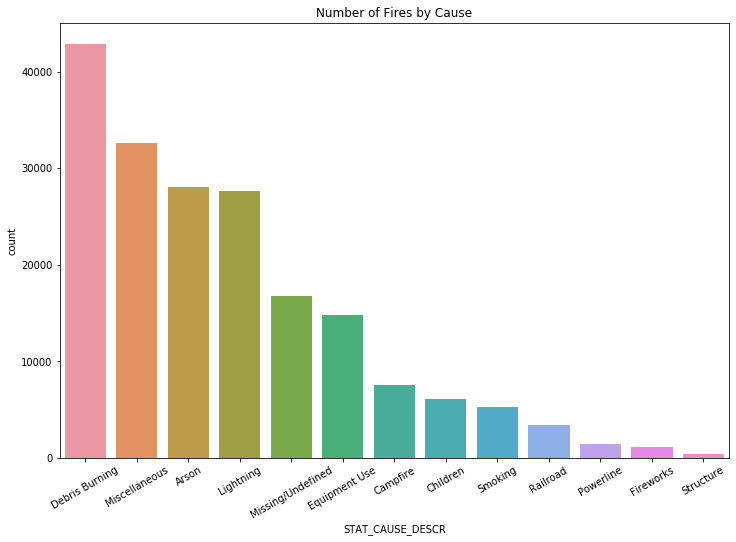

In [6]:
fig = plt.figure(figsize=(12,8))
fire_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR', 
                                data=fires_sample, 
                                order=fires_sample.STAT_CAUSE_DESCR.value_counts().index)
fire_cause_plot.set_title('Number of Fires by Cause')
fire_cause_plot.set_xticklabels(fire_cause_plot.get_xticklabels(), rotation=30);

## Feature exploration

### Fire size

A=greater than 0 but less than or equal to 0.25 acres<br />
B=0.26-9.9 acres<br />
C=10.0-99.9 acres<br />
D=100-299 acres<br />
E=300 to 999 acres<br />
F=1000 to 4999 acres<br />
G=5000+ acres

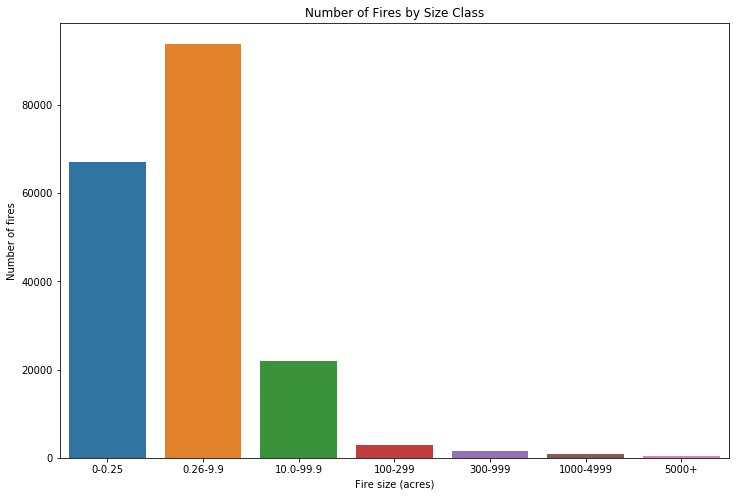

In [7]:
plt.figure(figsize=(12, 8))
fire_size_plot = sns.countplot(x='FIRE_SIZE_CLASS', data=fires_sample, order=['A','B','C','D','E','F','G'])
fire_size_plot.set_title('Number of Fires by Size Class')
fire_size_plot.set_xlabel('Fire size (acres)')
fire_size_plot.set_ylabel('Number of fires')
fire_size_plot.set_xticklabels(['0-0.25', '0.26-9.9', '10.0-99.9', '100-299', '300-999', '1000-4999', '5000+']);

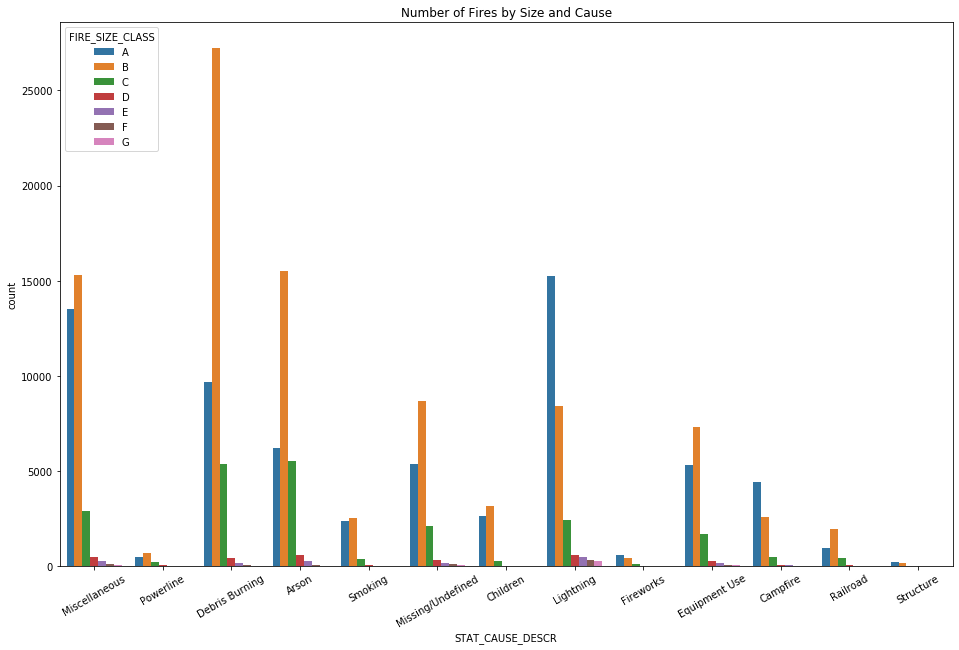

In [8]:
fig = plt.figure(figsize=(16,10))
size_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR',
                                hue='FIRE_SIZE_CLASS',
                                data=fires_sample,
                                hue_order=['A','B','C','D','E','F','G'])
size_cause_plot.set_title('Number of Fires by Size and Cause')
size_cause_plot.set_xticklabels(size_cause_plot.get_xticklabels(), rotation=30);

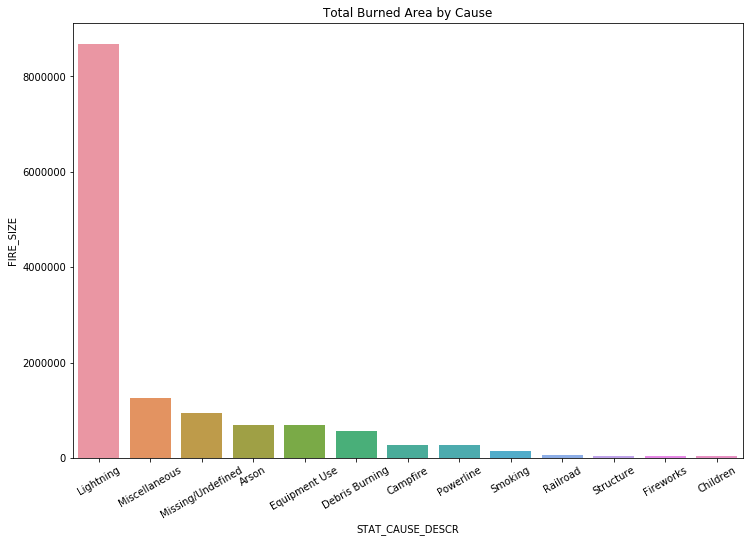

In [9]:
fire_size_by_cause = fires_sample.groupby(['STAT_CAUSE_DESCR'])['FIRE_SIZE'].sum().reset_index()

plt.figure(figsize=(12,8))
fire_size_by_cause_plot = sns.barplot(x='STAT_CAUSE_DESCR', 
                                      y='FIRE_SIZE', 
                                      data=fire_size_by_cause, 
                                      order=fire_size_by_cause.sort_values(by='FIRE_SIZE', ascending=False).STAT_CAUSE_DESCR.tolist())
fire_size_by_cause_plot.set_title('Total Burned Area by Cause')
fire_size_by_cause_plot.set_xticklabels(fire_size_by_cause_plot.get_xticklabels(), rotation=30);

It is shown that the majority of burned area is caused by lightning, which is a natural cause. People may argue that preventing natural fires disturbs the balance of the ecosystem, but as global temperature keeps rising, even natural fires caused by lightning will burn more severely. It is a complicated to figure out whether it is a good idea to mitigate fires no matter the cause, but for the purpose of analyzing wildfires, we will keep going.

### Latitude and longitude

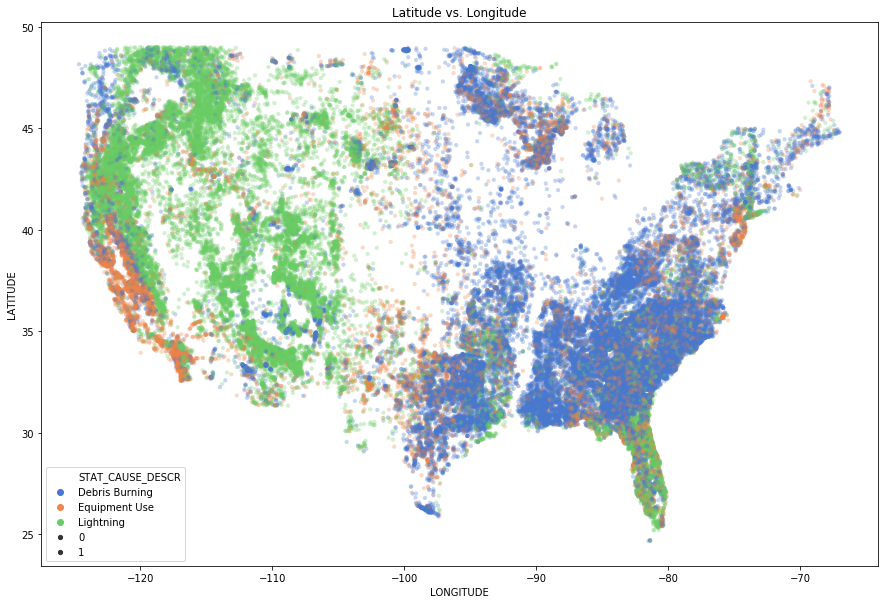

In [10]:
plt.figure(figsize=(15,10))
lat_lon_plot = sns.scatterplot(x='LONGITUDE',
                               y='LATITUDE',
                               data=fires[(fires['LONGITUDE']>-127) & 
                                          (fires['LONGITUDE']<-60) & 
                                          (fires['LATITUDE']<50) &
                                          (fires['LATITUDE']>22) &
                                          ((fires['STAT_CAUSE_DESCR']=='Lightning') |
                                           (fires['STAT_CAUSE_DESCR']=='Debris Burning') |
                                           (fires['STAT_CAUSE_DESCR']=='Equipment Use'))
                                         ].sample(80000),
                               hue='STAT_CAUSE_DESCR',
                               alpha=0.3,
                               size=1,
                               linewidth=0,
                               palette='muted')
lat_lon_plot.set_title('Latitude vs. Longitude');

### Fire year

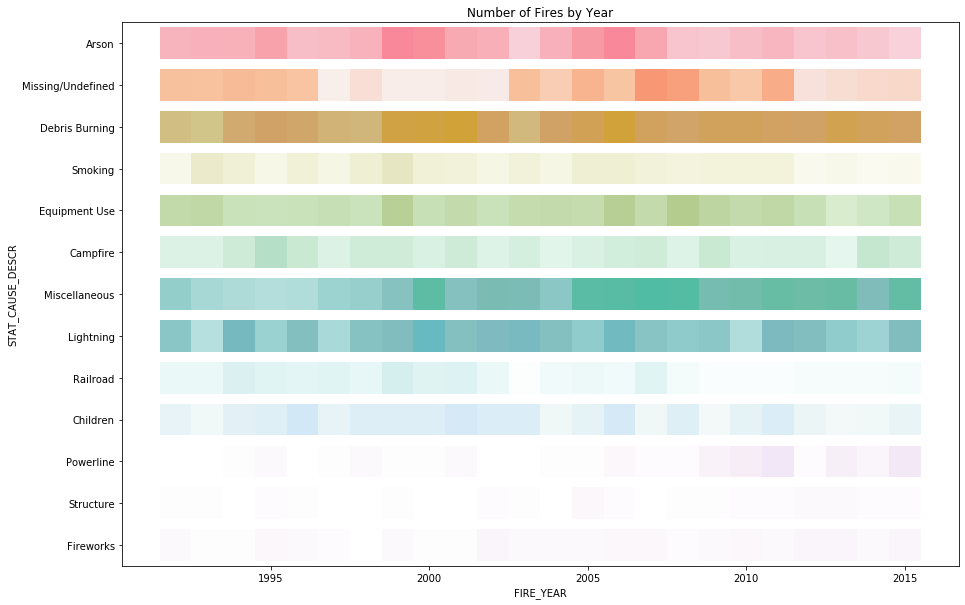

In [11]:
plt.figure(figsize=(15,10))
fire_by_year_plot = sns.stripplot(x='FIRE_YEAR', 
                                  y='STAT_CAUSE_DESCR', 
                                  data=fires.sample(10000), 
                                  size=31.7, 
                                  marker='s', 
                                  alpha=0.01,
                                  jitter=False)
fire_by_year_plot.set_title('Number of Fires by Year');

### Fire discovery day of year

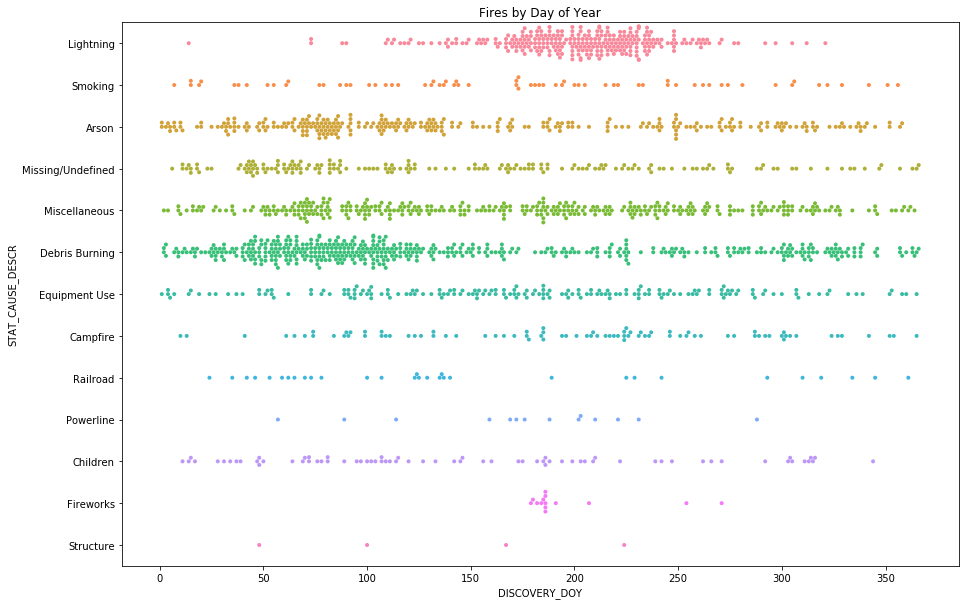

In [12]:
plt.figure(figsize=(15,10))
doy_cause_plot = sns.swarmplot(x='DISCOVERY_DOY', y='STAT_CAUSE_DESCR', data=fires.sample(2000), size=4)
doy_cause_plot.set_title('Fires by Day of Year');

### Fire discovery time of day

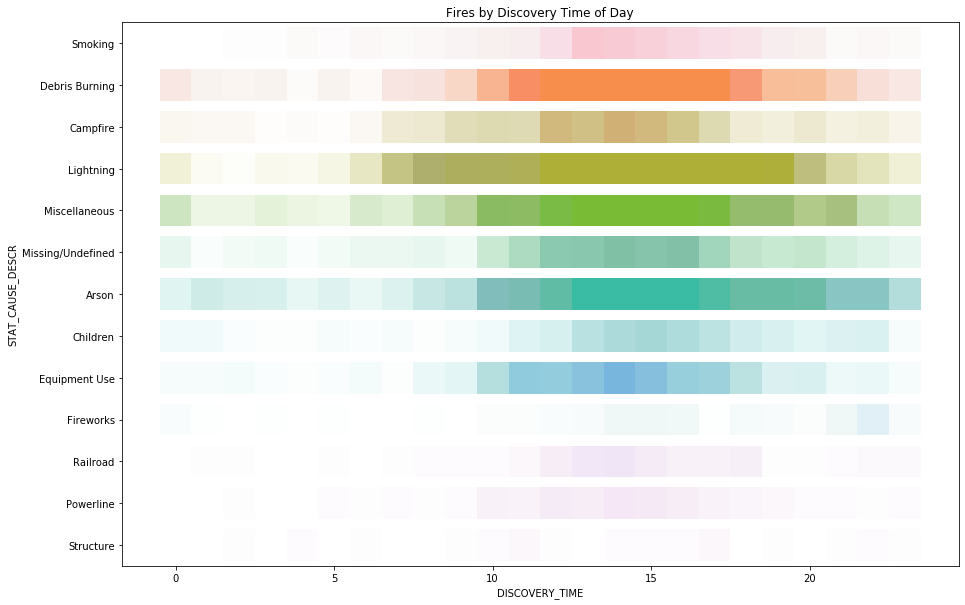

In [13]:
# drop missing DISCOVERY_TIME
fires_sample_with_time = fires_sample.dropna(subset=['DISCOVERY_TIME']).copy()
fires_sample_with_time['DISCOVERY_TIME'] = fires_sample_with_time['DISCOVERY_TIME'].astype(str).str[:2].astype(int)

plt.figure(figsize=(15,10))
time_cause_plot = sns.stripplot(x='DISCOVERY_TIME',
                                y='STAT_CAUSE_DESCR',
                                data=fires_sample_with_time.sample(10000), 
                                size=31.7, 
                                marker='s',
                                alpha=0.01,
                                jitter=False)
time_cause_plot.set_title('Fires by Discovery Time of Day');

The graph shows the relationship between fire discovery time of day and fire cause. DISCOVERY_TIME can be a helpful feature, however, there is too much missing data for the DISCOVERY_TIME column. If I only choose to use columns where DISCOVERY_TIME is not null, the rest of the data will be represented inaccurately. Maybe those where DISCOVERY_TIME is missing tend to be larger fires caused by lightning in remote areas.

## Select features

In [4]:
features = ['FIRE_YEAR', 'FIRE_SIZE', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']
X = fires_sample[features]
y = fires_sample['STAT_CAUSE_DESCR']

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Preliminary assessment of machine learning algorithms

In [24]:
dt_accuracies = []
rf_accuracies = []
gb_accuracies = []
xgb_accuracies = []
knn_accuracies = []

dt_f1_scores = []
rf_f1_scores = []
gb_f1_scores = []
xgb_f1_scores = []
knn_f1_scores = []

for x in range(3):
    boot = resample(fires_sample, replace=True, n_samples=len(fires_sample)) # bootstrap
    oob = pd.concat([fires_sample, boot]).drop_duplicates(keep=False) # out of bag samples
    
    boot_X = boot[features]
    boot_y = boot['STAT_CAUSE_DESCR']
    
    oob_X = oob[features]
    oob_y = oob['STAT_CAUSE_DESCR']
    
    print('---------- bootstrap run #', (x+1), '----------')
    
    # Decision tree
    dt_model = DecisionTreeClassifier(random_state=1)
    dt_model.fit(boot_X, boot_y)
    dt_prediction = dt_model.predict(oob_X)
    
    dt_accuracy = metrics.accuracy_score(oob_y, dt_prediction)
    dt_accuracies.append(dt_accuracy)
    dt_f1_score = metrics.f1_score(oob_y, dt_prediction, average='weighted')
    dt_f1_scores.append(dt_f1_score)
    print('Decision tree accuracy:', dt_accuracy, '   f1 score:', dt_f1_score)


    # Random forest
    rf_model = RandomForestClassifier(random_state=1)
    rf_model.fit(boot_X, boot_y)
    rf_prediction = rf_model.predict(oob_X)
    
    rf_accuracy = metrics.accuracy_score(oob_y, rf_prediction)
    rf_accuracies.append(rf_accuracy)
    rf_f1_score = metrics.f1_score(oob_y, rf_prediction, average='weighted')
    rf_f1_scores.append(rf_f1_score)
    print('Random forest accuracy:', rf_accuracy, '   f1 score:', rf_f1_score)


    # Gradient boosting
    gb_model = GradientBoostingClassifier(random_state=1)
    gb_model.fit(boot_X, boot_y)
    gb_prediction = gb_model.predict(oob_X)
    
    gb_accuracy = metrics.accuracy_score(oob_y, gb_prediction)
    gb_accuracies.append(gb_accuracy)
    gb_f1_score = metrics.f1_score(oob_y, gb_prediction, average='weighted')
    gb_f1_scores.append(gb_f1_score)
    print('Gradient boosting accuracy:', gb_accuracy, '   f1 score:', gb_f1_score)


    # XGBoost
    xgb_model = XGBClassifier(random_state=1)
    xgb_model.fit(boot_X, boot_y)
    xgb_prediction = xgb_model.predict(oob_X)
    
    xgb_accuracy = metrics.accuracy_score(oob_y, xgb_prediction)
    xgb_accuracies.append(xgb_accuracy)
    xgb_f1_score = metrics.f1_score(oob_y, xgb_prediction, average='weighted')
    xgb_f1_scores.append(xgb_f1_score)
    print('XGBoost accuracy:', xgb_accuracy, '   f1 score:', xgb_f1_score)


    # KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(boot_X, boot_y)
    knn_prediction = knn_model.predict(oob_X)
    
    knn_accuracy = metrics.accuracy_score(oob_y, knn_prediction)
    knn_accuracies.append(knn_accuracy)
    knn_f1_score = metrics.f1_score(oob_y, knn_prediction, average='weighted')
    knn_f1_scores.append(knn_f1_score)
    print('KNN accuracy:', knn_accuracy, '   f1 score:', knn_f1_score)

print('---------- Average ----------')
print('Average decision tree accuracy:', mean(dt_accuracies), '   f1 score:', mean(dt_f1_scores))
print('Average random forest accuracy:', mean(rf_accuracies), '   f1 score:', mean(rf_f1_scores))
print('Average gradient boosting accuracy:', mean(gb_accuracies), '   f1 score:', mean(gb_f1_scores))
print('Average XGBoost accuracy:', mean(xgb_accuracies), '   f1 score:', mean(xgb_f1_scores))
print('Average KNN accuracy:', mean(knn_accuracies), '   f1 score:', mean(knn_f1_scores))

---------- bootstrap run # 1 ----------
Decision tree accuracy: 0.42610680846144955    f1 score: 0.42720300021945734
Random forest accuracy: 0.5235810888914576    f1 score: 0.5036025844978298
Gradient boosting accuracy: 0.4765778522714137    f1 score: 0.4414625475801591
XGBoost accuracy: 0.4569702924517397    f1 score: 0.4117005840603879
KNN accuracy: 0.3849265980811467    f1 score: 0.37815726844670244
---------- bootstrap run # 2 ----------
Decision tree accuracy: 0.4231899159177412    f1 score: 0.42484879614748056
Random forest accuracy: 0.5269540803774295    f1 score: 0.5060111234996784
Gradient boosting accuracy: 0.4720184083705987    f1 score: 0.43520786151774304
XGBoost accuracy: 0.45297327023545925    f1 score: 0.4067562384905357
KNN accuracy: 0.38628634278354246    f1 score: 0.3784562356331497
---------- bootstrap run # 3 ----------
Decision tree accuracy: 0.4261511036391832    f1 score: 0.42799482780167075
Random forest accuracy: 0.5249931158422586    f1 score: 0.5045018656718

## Compare preliminary results
Looking at sample results for each algorithm helps with the understanding of data.

In [25]:
pd.DataFrame({'actual cause': oob_y,
              'decision tree': dt_prediction,
              'random forest': rf_prediction,
              'gradient boosting':gb_prediction,
              'xgboost': xgb_prediction,
              'knn':knn_prediction}).sample(20)

actual cause      decision tree      random forest  \
522724   Missing/Undefined  Missing/Undefined  Missing/Undefined   
1852984  Missing/Undefined  Missing/Undefined  Missing/Undefined   
304088           Lightning          Lightning          Lightning   
1608288              Arson            Smoking            Smoking   
1660598  Missing/Undefined            Smoking      Miscellaneous   
1666206      Miscellaneous              Arson      Miscellaneous   
1516907  Missing/Undefined  Missing/Undefined  Missing/Undefined   
406122           Lightning      Equipment Use          Lightning   
1847609      Miscellaneous      Miscellaneous      Miscellaneous   
1105978      Equipment Use      Equipment Use      Equipment Use   
1481965      Miscellaneous     Debris Burning      Miscellaneous   
779693   Missing/Undefined  Missing/Undefined  Missing/Undefined   
1177451      Equipment Use          Lightning      Equipment Use   
1644297          Lightning          Lightning          Lightning   
984857            Railroad           Railroad           Railroad   
771244       Miscellaneous      Miscellaneous      Miscellaneous   
476257               Arson              Arson              Arson   
1204561     Debris Burning          Lightning     Debris Burning   
1788076  Missing/Undefined  Missing/Undefined  Missing/Undefined   
514876      Debris Burning            Smoking      Miscellaneous   

         gradient boosting            xgboost                knn  
522724   Missing/Undefined     Debris Burning     Debris Burning  
1852984      Miscellaneous  Missing/Undefined  Missing/Undefined  
304088           Lightning          Lightning          Lightning  
1608288              Arson              Arson            Smoking  
1660598      Miscellaneous  Missing/Undefined           Children  
1666206      Miscellaneous      Miscellaneous      Miscellaneous  
1516907     Debris Burning     Debris Burning  Missing/Undefined  
406122           Lightning          Lightning          Lightning  
1847609     Debris Burning     Debris Burning              Arson  
1105978      Miscellaneous      Miscellaneous      Miscellaneous  
1481965     Debris Burning     Debris Burning          Lightning  
779693   Missing/Undefined  Missing/Undefined              Arson  
1177451          Lightning          Lightning      Miscellaneous  
1644297          Lightning          Lightning      Equipment Use  
984857            Railroad           Railroad     Debris Burning  
771244       Equipment Use          Lightning           Children  
476257      Debris Burning     Debris Burning              Arson  
1204561     Debris Burning     Debris Burning      Miscellaneous  
1788076      Miscellaneous          Lightning      Miscellaneous  
514876      Debris Burning     Debris Burning      Equipment Use

It seems like predicting some of these causes are not really that helpful. The purpose of this project is to speed up the process to decide the cause of a fire. When the cause is Miscellaneous or Missing/Undefined, it does not really make sense to predict for these causes with insufficient data.

## Filter out ambiguous causes (miscellaneous, missing/undefined)

In [5]:
fires_sample_nomisc = fires_sample[(fires_sample['STAT_CAUSE_DESCR']!='Miscellaneous') &
                                   (fires_sample['STAT_CAUSE_DESCR']!='Missing/Undefined')]

X = fires_sample_nomisc[features]
y = fires_sample_nomisc['STAT_CAUSE_DESCR']

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

# Full dataset
fires_nomisc = fires[(fires['STAT_CAUSE_DESCR']!='Miscellaneous') &
                     (fires['STAT_CAUSE_DESCR']!='Missing/Undefined')]

X_full = fires_nomisc[features]
y_full = fires_nomisc['STAT_CAUSE_DESCR']

train_X_full, val_X_full, train_y_full, val_y_full = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=1)

In [16]:
dt_accuracies = []
rf_accuracies = []
gb_accuracies = []
xgb_accuracies = []
knn_accuracies = []

dt_f1_scores = []
rf_f1_scores = []
gb_f1_scores = []
xgb_f1_scores = []
knn_f1_scores = []

for x in range(3):
    boot = resample(fires_sample_nomisc, replace=True, n_samples=len(fires_sample_nomisc)) # bootstrap
    oob = pd.concat([fires_sample_nomisc, boot]).drop_duplicates(keep=False) # out of bag samples
    
    boot_X = boot[features]
    boot_y = boot['STAT_CAUSE_DESCR']
    
    oob_X = oob[features]
    oob_y = oob['STAT_CAUSE_DESCR']
    
    print('---------- bootstrap run #', (x+1), '----------')
    
    # Decision tree
    dt_model = DecisionTreeClassifier(random_state=1)
    dt_model.fit(boot_X, boot_y)
    dt_prediction = dt_model.predict(oob_X)
    
    dt_accuracy = metrics.accuracy_score(oob_y, dt_prediction)
    dt_accuracies.append(dt_accuracy)
    dt_f1_score = metrics.f1_score(oob_y, dt_prediction, average='weighted')
    dt_f1_scores.append(dt_f1_score)
    print('Decision tree accuracy:', dt_accuracy, '   f1 score:', dt_f1_score)


    # Random forest
    rf_model = RandomForestClassifier(random_state=1)
    rf_model.fit(boot_X, boot_y)
    rf_prediction = rf_model.predict(oob_X)
    
    rf_accuracy = metrics.accuracy_score(oob_y, rf_prediction)
    rf_accuracies.append(rf_accuracy)
    rf_f1_score = metrics.f1_score(oob_y, rf_prediction, average='weighted')
    rf_f1_scores.append(rf_f1_score)
    print('Random forest accuracy:', rf_accuracy, '   f1 score:', rf_f1_score)


    # Gradient boosting
    gb_model = GradientBoostingClassifier(random_state=1)
    gb_model.fit(boot_X, boot_y)
    gb_prediction = gb_model.predict(oob_X)
    
    gb_accuracy = metrics.accuracy_score(oob_y, gb_prediction)
    gb_accuracies.append(gb_accuracy)
    gb_f1_score = metrics.f1_score(oob_y, gb_prediction, average='weighted')
    gb_f1_scores.append(gb_f1_score)
    print('Gradient boosting accuracy:', gb_accuracy, '   f1 score:', gb_f1_score)


    # XGBoost
    xgb_model = XGBClassifier(random_state=1)
    xgb_model.fit(boot_X, boot_y)
    xgb_prediction = xgb_model.predict(oob_X)
    
    xgb_accuracy = metrics.accuracy_score(oob_y, xgb_prediction)
    xgb_accuracies.append(xgb_accuracy)
    xgb_f1_score = metrics.f1_score(oob_y, xgb_prediction, average='weighted')
    xgb_f1_scores.append(xgb_f1_score)
    print('XGBoost accuracy:', xgb_accuracy, '   f1 score:', xgb_f1_score)


    # KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(boot_X, boot_y)
    knn_prediction = knn_model.predict(oob_X)
    
    knn_accuracy = metrics.accuracy_score(oob_y, knn_prediction)
    knn_accuracies.append(knn_accuracy)
    knn_f1_score = metrics.f1_score(oob_y, knn_prediction, average='weighted')
    knn_f1_scores.append(knn_f1_score)
    print('KNN accuracy:', knn_accuracy, '   f1 score:', knn_f1_score)

print('---------- Average ----------')
print('Average decision tree accuracy:', mean(dt_accuracies), '   f1 score:', mean(dt_f1_scores))
print('Average random forest accuracy:', mean(rf_accuracies), '   f1 score:', mean(rf_f1_scores))
print('Average gradient boosting accuracy:', mean(gb_accuracies), '   f1 score:', mean(gb_f1_scores))
print('Average XGBoost accuracy:', mean(xgb_accuracies), '   f1 score:', mean(xgb_f1_scores))
print('Average KNN accuracy:', mean(knn_accuracies), '   f1 score:', mean(knn_f1_scores))

---------- bootstrap run # 1 ----------
Decision tree accuracy: 0.44827789573012505    f1 score: 0.45087241001827644
Random forest accuracy: 0.5613548792954313    f1 score: 0.5352988762964895
Gradient boosting accuracy: 0.5366831799952819    f1 score: 0.49146960032553444
XGBoost accuracy: 0.5288000314539593    f1 score: 0.4734043003731268
KNN accuracy: 0.44230164346937173    f1 score: 0.4315647642837013
---------- bootstrap run # 2 ----------
Decision tree accuracy: 0.45273515286400373    f1 score: 0.4555521700412819
Random forest accuracy: 0.5616531958923899    f1 score: 0.5361389982152748
Gradient boosting accuracy: 0.5362539533794073    f1 score: 0.4924797377029704
XGBoost accuracy: 0.5276834172816368    f1 score: 0.4721531927560724
KNN accuracy: 0.440806684627699    f1 score: 0.42972707474199157
---------- bootstrap run # 3 ----------
Decision tree accuracy: 0.4503070855326413    f1 score: 0.4524437156760251
Random forest accuracy: 0.5591311343523733    f1 score: 0.5322868314852712

Random forest and gradient boosting achieve the highest accuracy with default settings. In the next section, we will focus on fine tuning these two algorithms.

## Fine tune random forest

### Randomized search

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [46]:
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 50, 
                               cv = 3, 
                               verbose=2, 
                               random_state=1, 
rand_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 45.5min
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 180.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [49]:
rand_search.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [9]:
rf_model_best_random = RandomForestClassifier(random_state=1, 
                                              n_estimators=700, 
                                              max_depth=80, 
                                              max_features='auto', 
                                              min_samples_split=5, 
                                              min_samples_leaf=4,
                                              bootstrap=True)
rf_model_best_random.fit(train_X, train_y)
rf_prediction_best_random = rf_model_best_random.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, rf_prediction_best_random),
      '   f1 score:', metrics.f1_score(val_y, rf_prediction_best_random, average='weighted'))

Accuracy: 0.57759117774254    f1 score: 0.5428970196669609


### Grid search

In [163]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [75, 80, 85, 150],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [700, 1000]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 211.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 291.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [167]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 700}

### Apply the best parameters

In [30]:
rf_model_best_grid = RandomForestClassifier(random_state=1, 
                                              n_estimators=700, 
                                              max_depth=75, 
                                              max_features='auto', 
                                              min_samples_split=6, 
                                              min_samples_leaf=3,
                                              bootstrap=True)
rf_model_best_grid.fit(train_X, train_y)
rf_prediction_best_grid = rf_model_best_grid.predict(val_X)

print('Accuracy when applied to 10% of the data:', metrics.accuracy_score(val_y, rf_prediction_best_grid),
      '   f1 score:', metrics.f1_score(val_y, rf_prediction_best_grid, average='weighted'))

rf_model_best_grid.fit(train_X_full, train_y_full)
rf_prediction_best_grid = rf_model_best_grid.predict(val_X_full)

print('Accuracy when applied to the full dataset:', metrics.accuracy_score(val_y_full, rf_prediction_best_grid),
      '   f1 score:', metrics.f1_score(val_y_full, rf_prediction_best_grid, average='weighted'))

Accuracy when applied to 10% of the data: 0.579140838979386    f1 score: 0.5459672279755791
Accuracy when applied to the full dataset: 0.6255989467171245    f1 score: 0.6002272433904884


### Evaluate model performance using confusion matrix

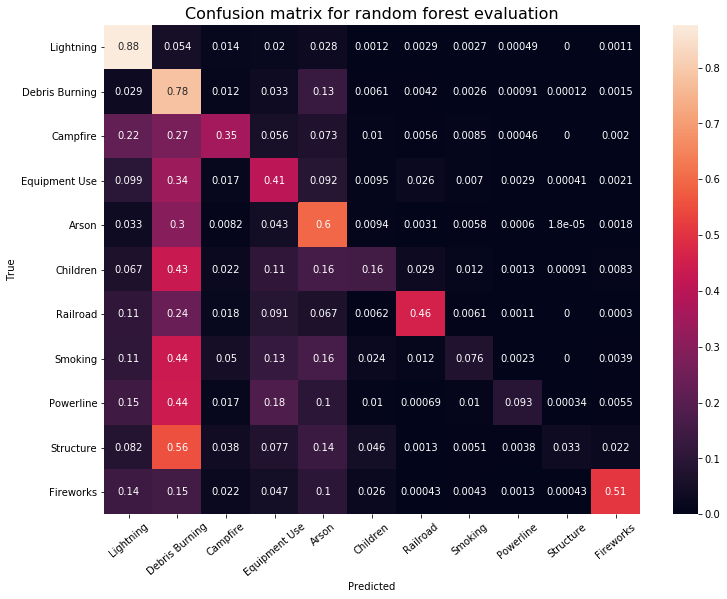

In [78]:
labels = fires_nomisc['STAT_CAUSE_DESCR'].unique()
cm = metrics.confusion_matrix(val_y_full, rf_prediction_best_grid, labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize to show percentage rather than count

plt.figure(figsize=(12,9))
plt.title('Confusion matrix for random forest evaluation', size=16)
ax = sns.heatmap(cmn, annot=True)
ax.set_xticklabels(labels, rotation=40)
ax.set_yticklabels(labels, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Fine tune gradient boosting

### Randomized search

In [26]:
# Number of trees in random forest
n_estimators = [100, 300, 500, 700, 900]
# Learning rate
learning_rate = [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]
# Maximum number of levels in tree
max_depth = [2, 3, 5, 7]
# Number of features to consider at every split
max_features = ['sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [100, 300, 500, 700, 900], 'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001], 'max_depth': [2, 3, 5, 7], 'max_features': ['sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [27]:
gb = GradientBoostingClassifier()
rand_search = RandomizedSearchCV(estimator = gb, 
                                 param_distributions = random_grid, 
                                 n_iter = 30, 
                                 cv = 3, 
                                 verbose=2, 
                                 random_state=1) 
rand_search.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, learning_rate=0.05 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, learning_rate=0.05, total= 4.9min
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, learning_rate=0.05 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, learning_rate=0.05, total= 4.7min
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, learning_rate=0.05 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=3, learning_rate=0.05, total= 4.5min
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, learning_rate=0.005 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, learning_rate=0.005, total=  34.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, learning_rate=0.005 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, learning_rate=0.005, total=  34.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, learning_rate=0.005 

[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, learning_rate=0.1, total= 2.8min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, learning_rate=0.05 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, learning_rate=0.05, total= 9.0min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, learning_rate=0.05 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, learning_rate=0.05, total= 9.1min
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, learning_rate=0.05 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, learning_rate=0.05, total= 9.0min
[CV] n_estimators=700, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, learning_rate=0.005 
[CV]  n_est

[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01, total= 1.8min
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01, total= 1.8min
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01, total= 1.8min
[CV] n_estimators=900, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01 
[CV]  n_estimators=900, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01, total= 5.3min
[CV] n_estimators=900, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=2, learning_rate=0.01 
[CV]  n_e

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 501.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [28]:
rand_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'learning_rate': 0.05}

In [10]:
gb_model_best_random = GradientBoostingClassifier(random_state=1, 
                                                 n_estimators=300, 
                                                 learning_rate=0.05,
                                                 max_depth=7, 
                                                 max_features='sqrt', 
                                                 min_samples_split=5, 
                                                 min_samples_leaf=2)
gb_model_best_random.fit(train_X, train_y)
gb_prediction_best_random = gb_model_best_random.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, gb_prediction_best_random),
      '   f1 score:', metrics.f1_score(val_y, gb_prediction_best_random, average='weighted'))

Accuracy: 0.5779876027101052    f1 score: 0.5458533973803449


### Grid search

In [86]:
param_grid = {
     'n_estimators': [200, 300, 400],
     'learning_rate': [0.03, 0.05, 0.07],
     'max_depth': [6, 7, 9],
     'max_features': ['sqrt'],
     'min_samples_split': [3, 5, 7],
     'min_samples_leaf': [2, 3],
}

gb = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 84.2min
/Users/maxpeng/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 518.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 1080.9min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 1528.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [87]:
grid_search.best_params_

{'learning_rate': 0.03,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 400}

### Apply the best parameters

In [6]:
gb_model_best_grid = GradientBoostingClassifier(random_state=1, 
                                                n_estimators=400, 
                                                learning_rate=0.03,
                                                max_depth=9, 
                                                max_features='sqrt', 
                                                min_samples_split=3, 
                                                min_samples_leaf=2)
gb_model_best_grid.fit(train_X, train_y)
gb_prediction_best_grid = gb_model_best_grid.predict(val_X)

print('Accuracy when applied to 10% of the data:', metrics.accuracy_score(val_y, gb_prediction_best_grid),
      '   f1 score:', metrics.f1_score(val_y, gb_prediction_best_grid, average='weighted'))

gb_model_best_grid.fit(train_X_full, train_y_full)
gb_prediction_best_grid = gb_model_best_grid.predict(val_X_full)

print('Accuracy when applied to the full dataset:', metrics.accuracy_score(val_y_full, gb_prediction_best_grid),
      '   f1 score:', metrics.f1_score(val_y_full, gb_prediction_best_grid, average='weighted'))

Accuracy when applied to 10% of the data: 0.5836817067896786    f1 score: 0.552912320739327
Accuracy when applied to the full dataset: 0.606112494064492    f1 score: 0.577623757506296


### Evaluate model performance using confusion matrix

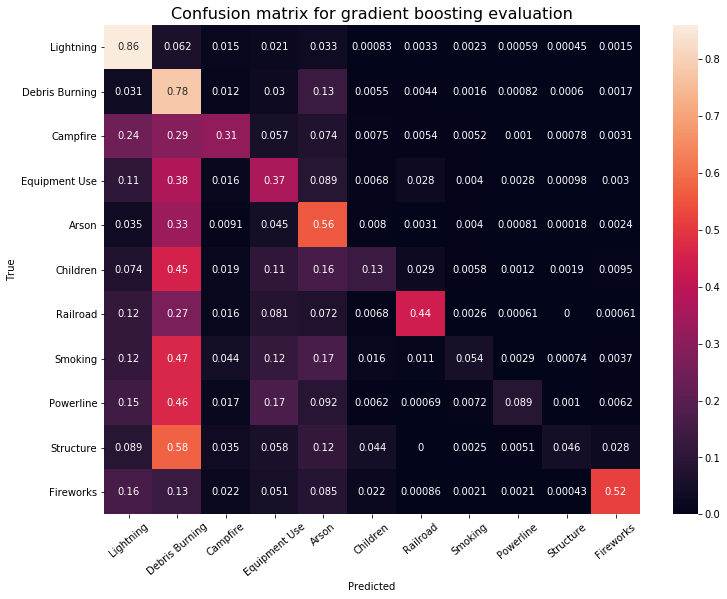

In [7]:
labels = fires_nomisc['STAT_CAUSE_DESCR'].unique()
cm = metrics.confusion_matrix(val_y_full, gb_prediction_best_grid, labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize to show percentage rather than count

plt.figure(figsize=(12,9))
plt.title('Confusion matrix for gradient boosting evaluation', size=16)
ax = sns.heatmap(cmn, annot=True)
ax.set_xticklabels(labels, rotation=40)
ax.set_yticklabels(labels, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()